In [61]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from dgllife.model import AttentiveFPPredictor
import torch
from rdkit import Chem
from torch import nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from dl_toolsets.utilities import load_dataset,collate_molgraphs
from torch.optim import lr_scheduler
from dgllife.utils import mol_to_bigraph, PretrainAtomFeaturizer, PretrainBondFeaturizer, AttentiveFPAtomFeaturizer, AttentiveFPBondFeaturizer
from dgllife.model import load_pretrained
from torch_geometric.data import Dataset, Data
import networkx as nx
import matplotlib.pyplot as plt
from dl_toolsets.utilities import make_gin_embedding, make_rdkit_descriptors, make_aft_embedding,make_ecfp,  make_clf_embeddings, attentive_fp_featurizers, make_datalist
atom_feat = AttentiveFPAtomFeaturizer()
bond_feat = AttentiveFPBondFeaturizer()
node_feat_size = atom_feat.feat_size()
edge_feat_size = bond_feat.feat_size()
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import transformers
print(transformers.__version__)

4.40.2


In [62]:
train_raw = pd.read_csv('mini_dataset/train_alc.csv')
test_raw= pd.read_csv('mini_dataset/test_alc.csv')
train_afp = attentive_fp_featurizers(train_raw['smiles'])
test_afp = attentive_fp_featurizers(test_raw['smiles'])
train_ecfp = make_ecfp(train_raw['smiles'])
test_ecfp = make_ecfp(test_raw['smiles'])

100%|██████████| 322/322 [00:00<00:00, 12546.83it/s]


In [63]:
from torch_geometric.loader import DataLoader
train_list = make_datalist(train_afp,train_ecfp , train_raw['rt'].values)
test_list = make_datalist(test_afp,test_ecfp , test_raw['rt'].values)
train_loader = DataLoader(train_list, batch_size=64, shuffle=True,)
test_loader = DataLoader(test_list, batch_size=64, shuffle=False, )

In [67]:
validation = pd.read_csv('mini_dataset/c18_all_meta.csv')

In [68]:
validation.dropna(subset=['smiles'], inplace=True)

In [69]:
model = AttentiveFPPredictor(node_feat_size=node_feat_size,
                                  edge_feat_size=edge_feat_size,
                                  num_layers=2,
                                  num_timesteps=2,
                                  graph_feat_size=256,
                                  n_tasks=1,
                                  dropout=0.0)
model = model.to('cpu')
model.load_state_dict(torch.load('models/best_my_ft_attfp.pth'))
loss_fn = nn.MSELoss()


In [70]:
validation_afp = attentive_fp_featurizers(validation['smiles'])
validation_ecfp = make_ecfp(validation['smiles'])
validation_list = make_datalist(validation_afp,validation_ecfp , validation['rt'].values)

100%|██████████| 3131/3131 [00:00<00:00, 12838.18it/s]


In [71]:
from torch_geometric.loader import DataLoader
validation_loader = DataLoader(validation_list, batch_size=64, shuffle=False,)

In [72]:
from dl_toolsets.super_model import test
from dl_toolsets.utilities import predict

refs, preds = test(model, validation_loader, return_values=True)

In [73]:
validation['predicted_rt']=preds

In [74]:
offset = abs(validation['predicted_rt']-validation['rt'])
validation['offset'] = offset

In [75]:
validation['offset'].quantile(0.8)

12.948932831175625

In [59]:
import seaborn as sns

In [85]:
validation.sort_values(by = 'offset', ascending=False)

,wiki_id,scan,rt,precursor_mz,charge,binbase-splash,user_annotation-name,key,smiles,msms,hidden,ms1_inte,adduct,method,predicted_rt,offset
1285,aYSUJ8A/TIPJ74MR,8426,344.649973,162.113016,1,splash10-03di-1900000000-c9b8fa967f7efdaa7d2f,zz_elution wash,8426,C[N+](C)(C)CC(CC(=O)[O-])O,60.08104\t13797.0\n66.550606\t1840.0\n72.15575...,False,724619.0,[M+H]+,5m splash one premier | orbitrap | beh c18 | p...,8.459267,336.190706
1312,aYSUJ8A/DNR87D41,8636,338.171800,432.238599,1,splash10-014r-1900000000-87eee9822abe031b4c83,zz_elution wash,8636,CC1C(C2(C(C2(C)C)C3C1(C4C=C(C(=O)C4CC(=C3)CO)C...,69.03363\t12384.0\n69.98429\t2116.0\n87.04418\...,False,1014588.0,[M+ACN+H]+,5m splash one premier | orbitrap | beh c18 | p...,17.133936,321.037864
1189,aYSUJ8A/742NDBSA,7395,319.544638,195.123319,1,splash10-000i-9600000000-99d631a0031434419d4e,zz_no peak,7395,C(COCCOCCOCCO)O,73.0648\t2538.0\n78.61735\t2356.0\n78.63006\t2...,False,2609287.0,[M+H]+,5m splash one premier | orbitrap | beh c18 | p...,10.945576,308.599062
1480,aYSUJ8A/Q310O1JL,11288,308.818417,1178.779993,1,splash10-0059-0392212000-32fda3f29d849a5e912e,zz_elution wash sodium formate cluster,11288,C(=O)[O-].[Na+],226.95148\t30948.0\n362.92578\t7869.0\n430.914...,False,374655.0,M+H,5m splash one premier | orbitrap | beh c18 | p...,5.031274,303.787143
1478,aYSUJ8A/4QMCM6ZW,11240,308.569414,974.814664,1,splash10-004i-0193400000-17113cfe9a0ab4d8e108,zz_elution wash sodium formate cluster,11240,C(=O)[O-].[Na+],158.9642\t26441.0\n196.564\t3296.0\n201.7384\t...,False,703061.0,M+H,5m splash one premier | orbitrap | beh c18 | p...,5.031274,303.538140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,aA9N54F/YXCQNY06,383,12.555635,285.043585,-1,splash10-000i-0090000000-af5dd60606f1340e87dc,oxazepam,383,C1=CC=C(C=C1)C2=NC(C(=O)NC3=C2C=C(C=C3)Cl)O,59.013607\t23216.0\n61.51781\t11471.0\n71.2598...,False,6558037.0,[M-H]-,5m splash one premier | orbitrap | beh c18 | n...,12.570807,0.015172
295,aYSUJ8A/PSVAL84T,479,157.303553,798.636551,1,splash10-001i-0900000100-ad719b29c03be82c6c76,PC O-18:0_20:3,479,CCCCCCCCCCCCCCCCCCOC[C@H](COP(=O)([O-])OCC[N+]...,86.09641\t279509.0\n88.738846\t31221.0\n104.10...,False,9801641.0,M+H,5m splash one premier | orbitrap | beh c18 | p...,157.313049,0.009497
305,aYSUJ8A/K0UBQU8I,497,234.947311,898.785521,1,splash10-0udi-0000009000-c9c8ec57f507a6b645bb,TG 18:1_18:2_18:2,497,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COC(=O)CCCCCC...,95.08573\t430938.0\n109.10109\t226722.0\n123.1...,False,157882784.0,M+NH4,5m splash one premier | orbitrap | beh c18 | p...,234.954529,0.007218
480,aYSUJ8A/UHL1CBKE,1057,11.862608,301.136877,1,splash10-0udi-4019000000-b52168e1bff6065c27e5,promethazine sulfoxide,1057,CC(CN1C2=CC=CC=C2S(=O)C3=CC=CC=C31)N(C)C,55.635628\t2411.0\n71.07291\t3630.0\n72.08015\...,False,1588638.0,[M+H]+,5m splash one premier | orbitrap | beh c18 | p...,11.859269,0.003338


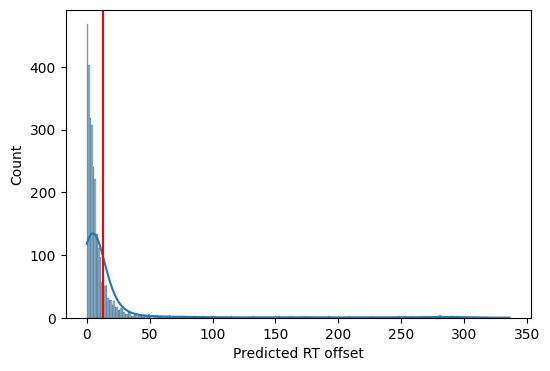

In [86]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6,4))
sns.histplot(validation['offset'], kde=True)
plt.xlabel('Predicted RT offset')
plt.axvline(validation['offset'].quantile(0.8), color='red',
            #  dashes = '--'
             )
plt.savefig('mass_wiki_rt_offset.png', dpi=300)


In [87]:
tag = []
for index, row in validation.iterrows():
    if row['offset'] < 13:
        tag.append(True)
    else:
        tag.append(False)
validation['tag'] = tag

In [88]:
negatives = validation[validation['user_annotation-name'].str.contains('zz|yy', case=False, na=False)]

In [89]:
negatives['tag'].describe()

count       253
unique        2
top       False
freq        211
Name: tag, dtype: object

In [58]:
217/252

0.8611111111111112

In [62]:
# data_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/metlin_smrt'
# data_subset = pd.read_csv(os.path.join(data_dir, 'SMRT_parsed.csv'))
# # data_all = pd.read_csv(os.path.join(data_dir, 'SMRT_parsed.csv'))
# train_df, test_df = train_test_split(data_subset, test_size=0.1, random_state=42)
# train_data = load_dataset(train_df, atom_feat, bond_feat)
# test_data = load_dataset(test_df, atom_feat, bond_feat)
# train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True,
#                               collate_fn=collate_molgraphs
#                               )
# test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False,collate_fn=collate_molgraphs)

<All keys matched successfully>

In [20]:
from dl_toolsets.super_model import train, test
from dl_toolsets.utilities import predict

In [80]:
train_raw= pd.read_csv('mini_dataset/train_alc.csv')

In [50]:
for i in range(0,9):
    _, dataset = train_test_split(train_raw, test_size=((i+1 )/ 10))
    dataset.to_csv('mini_dataset/train_alc_'+str(i+1)+'.csv', index=False)


In [81]:
df = train_raw.sample(frac=1, random_state=42).reset_index(drop=True)

In [82]:
df

,smiles,rt
0,CCCCCCCCC=CCCCCCCCC(=O)OCC(COC(=O)CCCCCCCC=CCC...,248.437120
1,CCCCCCCCCCCCCCCCC(=O)OC(COCCCCCCCCCCCCCC)COP(=...,123.921500
2,CCCCCCCCCCC=CCCCCCCCCCCCCOCC(O)COP(=O)(O)OCCN,95.132667
3,C1=CC=C(C(=C1)C(=O)O)C(=O)O,9.680105
4,CCCCN(CCC(=O)OCC)C(=O)C,13.259751
...,...,...
1282,CCC=CCC=CCC=CCC=CCCCCCCCCC(=O)OC(COC(=O)CCCCCC...,114.439427
1283,C(COCCOCCOCCOCCOCCO)O,11.729926
1284,CCCCCCCCCCCCCCCC=CC(O)C(CO)NC(=O)CCCCCCCCCCCCC...,224.795132
1285,CCCC=CCC=CCCCCCCCC(=O)OCCCCCCCCC=CCC=CCCC(=O)N...,177.715541


In [91]:
part_size = len(df) // 10

# Create a list to hold the 10 parts
parts = []
for i in range(10):
    if i < 9:
        part = df.iloc[i * part_size:(i + 1) * part_size]
    else:
        part = df.iloc[i * part_size:]  # Last part gets the remaining rows
    parts.append(part)
    # break

In [110]:
for i in range(len(parts)):
    out = pd.DataFrame()
    for j in range(i+1):
        out = pd.concat([out, parts[j]])
        out.to_csv('mini_dataset/train_alc_'+str(i+1)+'.csv', index = False) 

# lets try fine tunning first

In [65]:
from dl_toolsets.super_model import train, test
from dl_toolsets.utilities import predict

In [66]:
model = AttentiveFPPredictor(node_feat_size=node_feat_size,
                                  edge_feat_size=edge_feat_size,
                                  num_layers=2,
                                  num_timesteps=2,
                                  graph_feat_size=256,
                                  n_tasks=1,
                                  dropout=0.0)
model = model.to('cpu')
loss_fn = nn.MSELoss()
partition_size = 9
train_raw = pd.read_csv('mini_dataset/train_alc_'+str(partition_size)+'.csv')
print(len(train_raw))
train_afp = attentive_fp_featurizers(train_raw['smiles'])

train_ecfp = make_ecfp(train_raw['smiles'])
train_list = make_datalist(train_afp,train_ecfp , train_raw['rt'].values)
train_loader = DataLoader(train_list, batch_size=64, shuffle=True,)

model.load_state_dict(torch.load('models/best_my_trained_attfp.pth'))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, 
                             weight_decay=0.001,
                             )
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

max_epoch = 500
best_val_loss = float('inf')
for i in range(0, max_epoch):
    train(i, model, train_loader, loss_fn, optimizer)
    val_rmse = test(model, test_loader)
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(model.state_dict(), 'models/best_my_ft_attfp0903_'+str(partition_size)+'.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break
print(partition_size)
model.load_state_dict(torch.load('models/best_my_ft_attfp0903_'+str(partition_size)+'.pth'))
# model.load_state_dict(torch.load('models/best_my_ft_attfp.pth'))
# test(model, train_loader, verbose=True)
test(model, test_loader, verbose=True)

1152


100%|██████████| 1152/1152 [00:00<00:00, 12767.21it/s]


Epoch 0, RMSE: 1452.0852331407946
Epoch 1, RMSE: 491.72786871907107
Epoch 2, RMSE: 255.71157144153102
Epoch 3, RMSE: 163.52027527296798
Epoch 4, RMSE: 80.4475106813529
Epoch 5, RMSE: 49.81752163070521
Epoch 6, RMSE: 38.46147714358928
Epoch 7, RMSE: 32.88017574513935
Epoch 8, RMSE: 29.146620715478225
Epoch 9, RMSE: 26.533211455712205
Epoch 10, RMSE: 24.807573787674254
Epoch 11, RMSE: 23.639668355309084
Epoch 12, RMSE: 22.096131422590723
Epoch 13, RMSE: 20.946230863055895
Epoch 14, RMSE: 20.18838760424529
Epoch 15, RMSE: 19.451939318506728
Epoch 16, RMSE: 18.728870789790168
Epoch 17, RMSE: 18.21664029718918
Epoch 18, RMSE: 17.96495357785006
Epoch 19, RMSE: 18.029360361618473
Epoch 20, RMSE: 17.230901689975127
Epoch 21, RMSE: 17.08046962647285
Epoch 22, RMSE: 16.57198358127293
Epoch 23, RMSE: 16.352538203905166
Epoch 24, RMSE: 16.148502199826375
Epoch 25, RMSE: 15.73826043194998
Epoch 26, RMSE: 15.771056294177464
Epoch 27, RMSE: 16.64612912331797
Epoch 28, RMSE: 15.378360563663177
Epoch 2

tensor(15.0494, dtype=torch.float64)

In [126]:
model.load_state_dict(torch.load('models/best_my_ft_attfp0903_'+str(partition_size)+'.pth'))
# model.load_state_dict(torch.load('models/best_my_ft_attfp.pth'))
test(model, train_loader, verbose=True)
test(model, test_loader, verbose=True)

the testing rmse is 12.233930440224375, the mae is 4.697955846786499
the testing rmse is 14.870879551849672, the mae is 5.755428314208984


tensor(14.8709, dtype=torch.float64)

In [35]:
# model.load_state_dict(torch.load('models/best_my_ft_attfp0903.pth'))
model.load_state_dict(torch.load('models/best_my_ft_attfp.pth'))
test(model, train_loader, verbose=True)
test(model, test_loader, verbose=True)

the testing rmse is 11.602343619646685, the mae is 3.8681640625
the testing rmse is 13.233695869261458, the mae is 3.962677001953125


tensor(13.2337, dtype=torch.float64)

In [64]:
num_ftrs = 256
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.predict = nn.Sequential(
    nn.Dropout(p = 0.0, inplace=False),
    nn.Linear(num_ftrs, 1, bias = True),
                            )

model = model.to('cpu')



optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0003126662000605776,)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
max_epoch = 500
best_val_loss = float('inf')
saved = False
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
for i in range(0, max_epoch):
    train(model, train_loader, i, optimizer, loss_fn)
    val_rmse = test(model, test_loader, loss_fn).item()
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(model.state_dict(), 'models/best_my_ft_attfp.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break
# Decay LR by a factor of 0.1 every 7 epochs


ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
model.load_state_dict(torch.load('models/best_my_ft_attfp.pth'))
print('the training statistics are: ')
test(model, train_loader, loss_fn, verbose = True, return_rmse=False)
print('the testing statistics are: ')
test(model, test_loader, loss_fn, verbose = True,return_rmse=False)

the training statistics are: 
the rmse is 11.602343746135222, the mae is 3.8681640625
the testing statistics are: 
the rmse is 13.233696220919093, the mae is 3.962677001953125


()

# this time we use our pretrained model as an fixed embedding maker

In [26]:
train_raw = pd.read_csv(os.path.join('mini_dataset/train_alc.csv'))
test_raw = pd.read_csv(os.path.join('mini_dataset/test_alc.csv'))
# train_alc = load_dataset(train_raw, atom_feat, bond_feat)
# test_alc = load_dataset(test_raw, atom_feat, bond_feat)
# train_loader = DataLoader(dataset=train_alc, batch_size=64, shuffle=True,
#                               collate_fn=collate_molgraphs
#                               )
# test_loader = DataLoader(dataset=test_alc, batch_size=64, shuffle=False,collate_fn=collate_molgraphs)

In [ ]:
model = AttentiveFPPredictor(node_feat_size=node_feat_size,
                                  edge_feat_size=edge_feat_size,
                                  num_layers=2,
                                  num_timesteps=2,
                                  graph_feat_size=256,
                                  n_tasks=1,
                                  dropout=0.0)

loss_fn = nn.MSELoss()
model.load_state_dict(torch.load('models/best_my_trained_attfp.pth'))
for param in model.parameters():
    param.requires_grad = False
num_ftrs = 256
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.predict = nn.Sequential(
    nn.Dropout(p = 0.0, inplace=False),
    nn.Linear(num_ftrs, 64),
    nn.ReLU(),
    nn.Linear(64, 1, bias = True),
                            )
model = model.to('cpu')

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.predict.parameters(), lr=0.0001, weight_decay=0.0003126662000605776,)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
max_epoch = 500
best_val_loss = float('inf')
saved = False
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
for i in range(0, max_epoch):
    train(model, train_loader, i, optimizer, loss_fn)
    val_rmse = test(model, test_loader, loss_fn).item()
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(model.state_dict(), 'models/best_my_tsf_attfp.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break

this is epoch 0,the loss is 136.75684578578029
this is epoch 1,the loss is 122.01509109763951
this is epoch 2,the loss is 107.01716494516268
this is epoch 3,the loss is 92.00433059819386
this is epoch 4,the loss is 77.82362066037066
this is epoch 5,the loss is 64.47863516052294
this is epoch 6,the loss is 53.624322587434925
this is epoch 7,the loss is 45.87867326921208
this is epoch 8,the loss is 41.56333635254691
this is epoch 9,the loss is 39.35598471541167
this is epoch 10,the loss is 38.368926748996415
this is epoch 11,the loss is 37.89249257321862
this is epoch 12,the loss is 37.58098209947162
this is epoch 13,the loss is 37.21399956552332
this is epoch 14,the loss is 36.82313715251263
this is epoch 15,the loss is 36.42177296199461
this is epoch 16,the loss is 36.02282124285961
this is epoch 17,the loss is 35.6455347405272
this is epoch 18,the loss is 35.23198071232383
this is epoch 19,the loss is 34.80233925736848
this is epoch 20,the loss is 34.40833646677312
this is epoch 21,th

In [ ]:
model.load_state_dict(torch.load('models/best_my_tsf_attfp.pth'))
print('the training statistics are: ')
test(model, train_loader, loss_fn, verbose = True, return_rmse=False)
print('the testing statistics are: ')
test(model, test_loader, loss_fn, verbose = True,return_rmse=False)

the training statistics are: 
the rmse is 20.675861917971062, the mae is 11.010482788085938
the testing statistics are: 
the rmse is 19.307567672383776, the mae is 10.767457485198975


()

# use pretrained as featurizer?

In [3]:
train_raw = pd.read_csv(os.path.join('mini_dataset/train_alc.csv'))
test_raw = pd.read_csv(os.path.join('mini_dataset/test_alc.csv'))

In [ ]:

afp_embeding_train = make_aft_embedding(train_raw['smiles'])

gin_embeding_train = make_gin_embedding(train_raw['smiles'])
rdkit_des_train = make_rdkit_descriptors(train_raw['smiles'])


gin_supervised_contextpred_pre_trained.pth:   0%|          | 0.00/7.45M [00:00<?, ?B/s]

Pretrained model loaded
Processing batch 1/11
Processing batch 2/11
Processing batch 3/11
Processing batch 4/11
Processing batch 5/11
Processing batch 6/11
Processing batch 7/11
Processing batch 8/11
Processing batch 9/11
Processing batch 10/11
Processing batch 11/11


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [ ]:

afp_embeding_test = make_aft_embedding(test_raw['smiles'])

gin_embeding_test = make_gin_embedding(test_raw['smiles'])
rdkit_des_test = make_rdkit_descriptors(test_raw['smiles'])

gin_supervised_contextpred_pre_trained.pth:   0%|          | 0.00/7.45M [00:00<?, ?B/s]

Pretrained model loaded
Processing batch 1/3
Processing batch 2/3
Processing batch 3/3


In [ ]:
x1 = torch.tensor(afp_embeding_train, dtype=torch.float32)
x2 = torch.tensor(gin_embeding_train, dtype=torch.float32)
x3 = torch.tensor(rdkit_des_train, dtype=torch.float32)
y = torch.from_numpy(train_raw['rt'].values.astype(np.float32))
y  = y.view(y.shape[0],1)
train_multi_data = MultiInputDataset(x1, x2, x3, y)

In [ ]:
x1 = torch.tensor(afp_embeding_test, dtype=torch.float32)
x2 = torch.tensor(gin_embeding_test, dtype=torch.float32)
x3 = torch.tensor(rdkit_des_test, dtype=torch.float32)
y = torch.from_numpy(test_raw['rt'].values.astype(np.float32)).view(y.shape[0],1)
y  = y.view(y.shape[0],1)
test_multi_data = MultiInputDataset(x1, x2, x3, y)

# this is afp featurizer only

In [84]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
def train_simple_nn(model, train_loader, epoch, optimizer, loss_fn):
    model.train()
    train_loss = 0
    train_items = 0
    for data in (train_loader):
        x, y = data
        x, y = x.to('cpu'), y.to('cpu')

        
        y_pred = model(x)
        loss = loss_fn(y_pred, y.view(-1, 1))
        train_loss += loss.item()*len(y)
        train_items += len(y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, training rmse: {np.sqrt(train_loss / train_items)}')
def test_simple_nn(model, test_loader, loss_fn, verbose = False, return_rmse = True, return_values=False):
    model.eval()
    refs = []
    preds = []
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            x, y = x.to('cpu'), y.to('cpu')
            y_pred = model(x)
            preds.extend(y_pred)
            refs.extend(y)
    preds= np.array([i.item() for i in preds])
    refs = np.array([i.item() for i in refs])
    mse = loss_fn(torch.tensor(preds), torch.tensor(refs))
    mae = np.median(abs(preds-refs))
    if verbose:
        print(f'the rmse is {np.sqrt(mse)}, the mae is {mae}')
    if return_values == True:
        return preds, refs
    elif return_rmse:
        return np.sqrt(mse)
    else:
        return ()

In [ ]:
train_df = make_dataset(afp_embeding_train, train_raw['rt'].values)
test_df = make_dataset(afp_embeding_test, test_raw['rt'].values)
train_loader = DataLoader(train_df, batch_size=64, shuffle=True, num_workers=6)
test_loader = DataLoader(test_df, batch_size=64, shuffle=False, num_workers=6)

In [71]:
fc_model = SimpleMLP(input_dim=256)
fc_model = fc_model.to('cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001, weight_decay=0.0003126662000605776,)
max_epoch = 500
best_val_loss = float('inf')
for i in range(max_epoch):
    train_simple_nn(fc_model, train_loader, i, optimizer, loss_fn)
    val_rmse = test_simple_nn(fc_model, test_loader, loss_fn)
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(fc_model.state_dict(), 'models/best_afp_featurizer.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break

Epoch 0, training rmse: 93.50006414713621
Epoch 1, training rmse: 44.78855009727486
Epoch 2, training rmse: 37.65559651005242
Epoch 3, training rmse: 34.6529309648631
Epoch 4, training rmse: 32.57488996952491
Epoch 5, training rmse: 29.418243529372425
Epoch 6, training rmse: 26.785040117945428
Epoch 7, training rmse: 24.494184330250334
Epoch 8, training rmse: 23.324078322247416
Epoch 9, training rmse: 22.864654694034186
Epoch 10, training rmse: 22.975757494780883
Epoch 11, training rmse: 22.485025812889457
Epoch 12, training rmse: 22.766221815394566
Epoch 13, training rmse: 22.81970751542837
Epoch 14, training rmse: 22.43339486770341
Epoch 15, training rmse: 21.83890523887797
Epoch 16, training rmse: 21.748589673073603
Epoch 17, training rmse: 21.77213496387049
Epoch 18, training rmse: 21.736052723731703
Epoch 19, training rmse: 21.806973965379022
Epoch 20, training rmse: 22.504599362678167
Epoch 21, training rmse: 21.743081844783624
Epoch 22, training rmse: 22.349070629789185
Epoch 23

In [72]:
fc_model.load_state_dict(torch.load('models/best_afp_featurizer.pth'))
print('this is the training statistics')
test_simple_nn(fc_model, train_loader, loss_fn, verbose = True)
print('this is the testing statistics')
test_simple_nn(fc_model, test_loader, loss_fn, verbose = True)

this is the training statistics
the rmse is 15.757693206970032, the mae is 7.5129852294921875
this is the testing statistics
the rmse is 16.235132213696666, the mae is 7.2605438232421875


tensor(16.2351, dtype=torch.float64)

# lets try gin featurizer

In [73]:
train_df = make_dataset(gin_embeding_train, train_raw['rt'].values)
test_df = make_dataset(gin_embeding_test, test_raw['rt'].values)
train_loader = DataLoader(train_df, batch_size=64, shuffle=True, num_workers=6)
test_loader = DataLoader(test_df, batch_size=64, shuffle=False, num_workers=6)

In [86]:
fc_model = SimpleMLP(input_dim=gin_embeding_train[0].shape[0])
fc_model = fc_model.to('cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)
max_epoch = 500
best_val_loss = float('inf')
for i in range(max_epoch):
    train_simple_nn(fc_model, train_loader, i, optimizer, loss_fn)
    val_rmse = test_simple_nn(fc_model, test_loader, loss_fn)
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(fc_model.state_dict(), 'models/best_gin_featurizer.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break

Epoch 0, training rmse: 137.62884338425002
Epoch 1, training rmse: 126.92388452557742
Epoch 2, training rmse: 89.66154194183896
Epoch 3, training rmse: 50.15734302931893
Epoch 4, training rmse: 45.96680292368452
Epoch 5, training rmse: 44.28031541490007
Epoch 6, training rmse: 42.67744165360733
Epoch 7, training rmse: 41.581873835563776
Epoch 8, training rmse: 40.564073722944464
Epoch 9, training rmse: 39.52769133809849
Epoch 10, training rmse: 38.59505143346867
Epoch 11, training rmse: 37.544758307970916
Epoch 12, training rmse: 36.638660229825405
Epoch 13, training rmse: 35.72815595793434
Epoch 14, training rmse: 34.77606615067024
Epoch 15, training rmse: 34.17305962905904
Epoch 16, training rmse: 33.29732299205147
Epoch 17, training rmse: 32.45674102570495
Epoch 18, training rmse: 31.74788639677904
Epoch 19, training rmse: 31.115183143284735
Epoch 20, training rmse: 30.469578054134278
Epoch 21, training rmse: 29.864018561979666
Epoch 22, training rmse: 29.52606757968239
Epoch 23, tr

In [87]:
fc_model.load_state_dict(torch.load('models/best_gin_featurizer.pth'))
print('this is the training statistics')
test_simple_nn(fc_model, train_loader, loss_fn, verbose = True)
print('this is the testing statistics')
test_simple_nn(fc_model, test_loader, loss_fn, verbose = True)

this is the training statistics
the rmse is 13.945336224278513, the mae is 5.2879638671875
this is the testing statistics
the rmse is 19.715803901658568, the mae is 7.7261199951171875


tensor(19.7158, dtype=torch.float64)

# lets try rdkit descirptors only

In [88]:
train_df = make_dataset(rdkit_des_train, train_raw['rt'].values)
test_df = make_dataset(rdkit_des_test, test_raw['rt'].values)
train_loader = DataLoader(train_df, batch_size=64, shuffle=True, num_workers=6)
test_loader = DataLoader(test_df, batch_size=64, shuffle=False, num_workers=6)

In [89]:
fc_model = SimpleMLP(input_dim=rdkit_des_train[0].shape[0])
fc_model = fc_model.to('cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)
max_epoch = 500
best_val_loss = float('inf')
for i in range(max_epoch):
    train_simple_nn(fc_model, train_loader, i, optimizer, loss_fn)
    val_rmse = test_simple_nn(fc_model, test_loader, loss_fn)
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(fc_model.state_dict(), 'models/best_rdkit_featurizer.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break

Epoch 0, training rmse: 71.19587368385241
Epoch 1, training rmse: 42.33739886952783
Epoch 2, training rmse: 27.695124163659127
Epoch 3, training rmse: 22.686126226920294
Epoch 4, training rmse: 21.13158070725923
Epoch 5, training rmse: 20.851550647068482
Epoch 6, training rmse: 21.42709641028066
Epoch 7, training rmse: 20.335070440983635
Epoch 8, training rmse: 19.682056176071722
Epoch 9, training rmse: 19.468168724825443
Epoch 10, training rmse: 19.06062126945776
Epoch 11, training rmse: 20.07518751798812
Epoch 12, training rmse: 19.3215138555245
Epoch 13, training rmse: 18.886477447645625
Epoch 14, training rmse: 19.08598809006234
Epoch 15, training rmse: 18.299610877830418
Epoch 16, training rmse: 18.563048266410483
Epoch 17, training rmse: 17.631450836743383
Epoch 18, training rmse: 17.89233441000554
Epoch 19, training rmse: 17.19799384469063
Epoch 20, training rmse: 17.05473018543683
Epoch 21, training rmse: 17.266595848401
Epoch 22, training rmse: 18.386421519936174
Epoch 23, tra

In [90]:
fc_model.load_state_dict(torch.load('models/best_rdkit_featurizer.pth'))
print('this is the training statistics')
test_simple_nn(fc_model, train_loader, loss_fn, verbose = True)
print('this is the testing statistics')
test_simple_nn(fc_model, test_loader, loss_fn, verbose = True)

this is the training statistics
the rmse is 13.019986079193677, the mae is 5.598901748657227
this is the testing statistics
the rmse is 14.73400650043799, the mae is 6.334228515625


tensor(14.7340, dtype=torch.float64)

# maybe bert as well?

In [106]:

train_bert_embedding = make_clf_embeddings(train_raw['smiles'], attention_pooling=True)
test_bert_embedding = make_clf_embeddings(test_raw['smiles'], attention_pooling=True)
train_df = make_dataset(train_bert_embedding, train_raw['rt'].values)
test_df = make_dataset(test_bert_embedding, test_raw['rt'].values)
train_loader = DataLoader(train_df, batch_size=64, shuffle=True, num_workers=6)
test_loader = DataLoader(test_df, batch_size=64, shuffle=False, num_workers=6)

100%|██████████| 322/322 [00:12<00:00, 25.89it/s]


In [ ]:
fc_model = SimpleMLP(input_dim=train_bert_embedding[0].shape[0])
fc_model = fc_model.to('cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)
max_epoch = 500
best_val_loss = float('inf')
for i in range(max_epoch):
    train_simple_nn(fc_model, train_loader, i, optimizer, loss_fn)
    val_rmse = test_simple_nn(fc_model, test_loader, loss_fn)
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(fc_model.state_dict(), 'models/best_bert_featurizer.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break
fc_model.load_state_dict(torch.load('models/best_bert_featurizer.pth'))
print('this is the training statistics')
test_simple_nn(fc_model, train_loader, loss_fn, verbose = True)
print('this is the testing statistics')
test_simple_nn(fc_model, test_loader, loss_fn, verbose = True)

Epoch 0, training rmse: 117.04436826869265
Epoch 1, training rmse: 76.40097919272168
Epoch 2, training rmse: 67.00573752194056
Epoch 3, training rmse: 61.859084054880576
Epoch 4, training rmse: 58.990069252401284
Epoch 5, training rmse: 57.858466115519974
Epoch 6, training rmse: 55.82698502313838
Epoch 7, training rmse: 54.60157872500633
Epoch 8, training rmse: 53.072203488502055
Epoch 9, training rmse: 51.22257966673793
Epoch 10, training rmse: 50.24812381467169
Epoch 11, training rmse: 48.8437107118571
Epoch 12, training rmse: 48.40138102309951
Epoch 13, training rmse: 46.51430188928604
Epoch 14, training rmse: 45.16404345897855
Epoch 15, training rmse: 44.155365336719434
Epoch 16, training rmse: 43.041430005126806
Epoch 17, training rmse: 42.210616329716096
Epoch 18, training rmse: 41.23515965079172
Epoch 19, training rmse: 41.0055817811317
Epoch 20, training rmse: 39.16492540995183
Epoch 21, training rmse: 38.62436921336199
Epoch 22, training rmse: 37.58043791959486
Epoch 23, train

# lets super

In [8]:
from dl_toolsets.utilities import make_ecfp, make_aft_embedding, make_datalist, attentive_fp_featurizers
train_raw = pd.read_csv(os.path.join('mini_dataset/train_alc.csv'))
test_raw = pd.read_csv(os.path.join('mini_dataset/test_alc.csv'))
train_ecfp = make_ecfp(train_raw['smiles'])
test_ecfp = make_ecfp(test_raw['smiles'])
train_afp = attentive_fp_featurizers(train_raw['smiles'])
test_afp = attentive_fp_featurizers(test_raw['smiles'])
train_list = make_datalist(train_afp, train_ecfp,train_raw['rt'].values)
test_list = make_datalist(test_afp, test_ecfp, test_raw['rt'].values)

100%|██████████| 322/322 [00:00<00:00, 10832.26it/s]


In [78]:
data_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/metlin_smrt'
data_subset = pd.read_csv(os.path.join(data_dir, 'SMRT_dataset.csv'), delimiter=';')

In [85]:
from tqdm import tqdm

In [93]:
smiles = []
for index, row in tqdm(data_subset.iterrows(), total = len(data_subset)):
    mol = Chem.MolFromInchi(row['inchi'])
    if mol is not None:
        smiles.append(Chem.MolToSmiles(mol))
    else:
        smiles.append(np.NAN)

100%|██████████| 80038/80038 [00:28<00:00, 2772.97it/s]


In [94]:
data_subset['smiles'] = smiles
data_subset = data_subset.dropna(subset = ['smiles'])

In [95]:
data_subset.to_csv(os.path.join(data_dir, 'SMRT_dataset_cleaned.csv'), index = False)

In [96]:
data_subset

,pubchem,rt,inchi,smiles
0,5139,93.5,"InChI=1S/C3H8N2S/c1-2-6-3(4)5/h2H2,1H3,(H3,4,5)",CCSC(=N)N
1,3505,687.8,InChI=1S/C19H25Cl2N3O3/c1-27-19(26)23-8-9-24(1...,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...
2,2159,590.7,InChI=1S/C17H27N3O4S/c1-4-20-8-6-7-12(20)11-19...,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1OC
3,1340,583.6,InChI=1S/C9H7NO2/c11-8-3-1-2-7-6(8)4-5-10-9(7)...,Oc1cccc2c(O)nccc12
4,3344,579.0,InChI=1S/C15H20N2O2/c18-14-16-12-15(19-14)7-10...,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1
...,...,...,...,...
80033,97733655,946.4,InChI=1S/C25H29N3O6S/c1-5-24(29)26-25-17(4)27-...,CCOc1ccc(OCC)c(NS(=O)(=O)c2ccc(/C=C/c3onc(C)c3...
80034,98666786,653.1,InChI=1S/C17H24FN3O5S/c1-25-7-3-6-19-17(22)20-...,COCCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(F)c3)C...
80035,98670835,648.2,InChI=1S/C17H25N3O5S/c1-13-4-3-5-16(8-13)26(22...,COCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(C)c3)C[...
80036,98779314,783.9,InChI=1S/C21H25N3O4S/c1-15-7-9-19(10-8-15)29(2...,Cc1ccc(S(=O)(=O)N2C[C@@H]3CN(C(O)=Nc4ccccc4C)C...


In [13]:
from dl_toolsets.utilities import predict_super
from dl_toolsets.super_model import Super, train_super, test_super

In [32]:
for d in train_loader:
    break

In [36]:
data.ecfp.shape

torch.Size([64, 2048])

In [71]:
from dl_toolsets.super_model import Super, Super_2
model = Super_2(
    node_feat_size=node_feat_size,
    edge_feat_size=edge_feat_size,
    num_layers=2,   
    num_timesteps=2,
    graph_feat_size=512,
    feat_size = 256,
)


In [72]:
test = predict_super(model, d)

In [74]:

from torch_geometric.loader import DataLoader
from dl_toolsets.super_model import Super, Super_2
# from torch.utils.data import DataLoader
train_loader = DataLoader(train_list, batch_size=64, shuffle=True, 
                        #   collate_fn=collate
                          )
test_loader = DataLoader(test_list, batch_size=64, shuffle=False,)
model = Super_2(
    node_feat_size=node_feat_size,
    edge_feat_size=edge_feat_size,
    num_layers=2,   
    num_timesteps=2,
    graph_feat_size=512,
    feat_size = 512,
)

model = model.to('cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
max_epoch = 500
best_val_loss = float('inf')
for i in range(max_epoch):
    train_super( i,model, train_loader, loss_fn,optimizer)
    val_rmse = test_super(model, test_loader)
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(model.state_dict(), 'models/best_super_2.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break

Epoch 0, RMSE: 137.2999304722866
Epoch 1, RMSE: 89.31967626617396
Epoch 2, RMSE: 47.49396444092854
Epoch 3, RMSE: 44.889405688223334
Epoch 4, RMSE: 43.759443157577465
Epoch 5, RMSE: 42.36692281570951
Epoch 6, RMSE: 40.06884695461606
Epoch 7, RMSE: 37.15672413914334
Epoch 8, RMSE: 33.20362154691785
Epoch 9, RMSE: 31.95407658915447
Epoch 10, RMSE: 27.78972640137796
Epoch 11, RMSE: 26.52137635454736
Epoch 12, RMSE: 26.495725796691364
Epoch 13, RMSE: 24.64473687817694
Epoch 14, RMSE: 25.683790540434146
Epoch 15, RMSE: 24.30784288228249
Epoch 16, RMSE: 22.374993369596062
Epoch 17, RMSE: 21.861748511059865
Epoch 18, RMSE: 21.58254204972658
Epoch 19, RMSE: 20.420013072478508
Epoch 20, RMSE: 20.007457242473567
Epoch 21, RMSE: 20.489749657786184
Epoch 22, RMSE: 18.971629456012128
Epoch 23, RMSE: 18.583820557416942
Epoch 24, RMSE: 18.508366928431784
Epoch 25, RMSE: 18.136229347904244
Epoch 26, RMSE: 18.395138966959248
Epoch 27, RMSE: 18.03172215571598
Epoch 28, RMSE: 18.332009973799163
Epoch 29,

In [75]:

model.load_state_dict(torch.load('models/best_super_2.pth'))
print('this is the training statistics')
test_super(model, train_loader, verbose = True)
print('this is the testing statistics')
test_super(model, test_loader, verbose = True)

this is the training statistics
the testing rmse is 15.81350168580622, the mae is 5.657388687133789
this is the testing statistics
the testing rmse is 15.320936373520071, the mae is 5.836612701416016


tensor(15.3209, dtype=torch.float64)

In [39]:


model.load_state_dict(torch.load('models/best_super_2.pth'))
print('this is the training statistics')
test_super(model, train_loader, verbose = True)
print('this is the testing statistics')
test_super(model, test_loader, verbose = True)

this is the training statistics
the testing rmse is 15.097013631241326, the mae is 5.775764465332031
this is the testing statistics
the testing rmse is 14.391841980411714, the mae is 6.10150146484375


tensor(14.3918, dtype=torch.float64)

In [566]:
from dl_toolsets.super_model import TransforerBlock
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.input_dim = input_dim  
        self.conv1d = TransforerBlock(in_channel=self.input_dim, out_channel=self.input_dim)
        self.feat_size = input_dim
        self.predict = nn.Sequential(
            nn.Linear(self.feat_size, self.feat_size // 8),
            nn.ReLU(inplace=True),
            # nn.BatchNorm1d(self.feat_size // 8),
            nn.Linear(self.feat_size // 8, self.feat_size // 64),
            # nn.BatchNorm1d(self.feat_size // 64),
            nn.ReLU(inplace=True),
            nn.Linear(self.feat_size // 64, 1),
        )

    def forward(self, x):
        x = self.conv1d(x)
        return self.predict(x)

In [510]:
from dl_toolsets.super_model import train_super

In [571]:
model = SimpleMLP(input_dim=2048)

In [572]:

model = model.to('cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
max_epoch = 1000
best_val_loss = float('inf')
for i in range(max_epoch):
    train_super( i,model, train_loader, loss_fn,optimizer, super = False)
    val_rmse = test_super(model, test_loader, super = False)
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(model.state_dict(), 'models/best_super.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break

Epoch 0, RMSE: 140.58605576658894
Epoch 1, RMSE: 116.44050657074675
Epoch 2, RMSE: 121.03515497466495
Epoch 3, RMSE: 120.26551485801367
Epoch 4, RMSE: 118.81958623579054
Epoch 5, RMSE: 120.99330583059783
Epoch 6, RMSE: 120.84813183974633
Epoch 7, RMSE: 123.53865834598925
Epoch 8, RMSE: 118.30198368856038
Epoch 9, RMSE: 117.0678088123619
Epoch 10, RMSE: 119.88779949804278
Epoch 11, RMSE: 119.25275407936823
Epoch 12, RMSE: 116.16510034898526
Epoch 13, RMSE: 116.06474447613729
Epoch 14, RMSE: 114.65902725044253
Epoch 15, RMSE: 124.00225282498499


KeyboardInterrupt: 

In [558]:
model.load_state_dict(torch.load('models/best_super.pth'))
print('this is the training statistics')
test_super(model, train_loader, verbose = True, super = False)
print('this is the testing statistics')
test_super(model, test_loader, verbose = True, super= False)

this is the training statistics
the testing rmse is 15.406994999095351, the mae is 6.999534606933594
this is the testing statistics
the testing rmse is 16.190607035764003, the mae is 6.488086700439453


tensor(16.1906, dtype=torch.float64)

In [136]:
fc_model = SimpleMLP(input_dim=train_df.tensors[0].shape[1])
fc_model = fc_model.to('cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)
max_epoch = 500
best_val_loss = float('inf')
for i in range(max_epoch):
    train_simple_nn(fc_model, train_loader, i, optimizer, loss_fn)
    val_rmse = test_simple_nn(fc_model, test_loader, loss_fn)
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(fc_model.state_dict(), 'models/best_ecfp_featurizer.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break
fc_model.load_state_dict(torch.load('models/best_ecfp_featurizer.pth'))
print('this is the training statistics')
test_simple_nn(fc_model, train_loader, loss_fn, verbose = True)
print('this is the testing statistics')
test_simple_nn(fc_model, test_loader, loss_fn, verbose = True)

Epoch 0, training rmse: 137.46802568033874
Epoch 1, training rmse: 120.83760954015821
Epoch 2, training rmse: 75.56717185693189
Epoch 3, training rmse: 58.73008380625916
Epoch 4, training rmse: 52.54098131974022
Epoch 5, training rmse: 47.99334741634914
Epoch 6, training rmse: 44.197181469263995
Epoch 7, training rmse: 40.32111023617902
Epoch 8, training rmse: 36.9559742046515
Epoch 9, training rmse: 34.16508074293935
Epoch 10, training rmse: 31.793066285341027
Epoch 11, training rmse: 29.884330364050292
Epoch 12, training rmse: 28.422565152469264
Epoch 13, training rmse: 26.95229546940466
Epoch 14, training rmse: 25.836184311329312
Epoch 15, training rmse: 24.74795703408616
Epoch 16, training rmse: 23.973106368501675
Epoch 17, training rmse: 23.210600356839137
Epoch 18, training rmse: 22.751336055708794
Epoch 19, training rmse: 22.263768090925712
Epoch 20, training rmse: 21.742844470096163
Epoch 21, training rmse: 21.36221382596325
Epoch 22, training rmse: 21.022285974879576
Epoch 23,

tensor(22.6305, dtype=torch.float64)

In [263]:
class MultiInputNN(nn.Module):
    def __init__(self, input_dim1, input_dim2, input_dim3, hidden_dim1, hidden_dim2, hidden_dim3, final_hidden_dim):
        super(MultiInputNN, self).__init__()
        
        # Fully connected layers for each input set
        self.fc1 = nn.Sequential(
            nn.Linear(input_dim1, hidden_dim1),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(input_dim2, hidden_dim2),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(input_dim3, hidden_dim3),
            nn.ReLU()
        )
        
        # Fully connected layer to fuse the outputs
        self.fc_final = nn.Sequential(
            nn.Linear(hidden_dim1 + hidden_dim2 + hidden_dim3, final_hidden_dim),
            nn.ReLU(),
            nn.Linear(final_hidden_dim, 1)  # Assuming a regression task, change output accordingly
        )

    def forward(self, x1, x2, x3):
        # Forward pass for each set of features
        out1 = self.fc1(x1)
        out2 = self.fc2(x2)
        out3 = self.fc3(x3)
        
        # Concatenate the outputs
        combined = torch.cat((out1, out2, out3), dim=1)
        
        # Pass through the final fully connected layer
        output = self.fc_final(combined)
        
        return output
input_dim1, input_dim2, input_dim3 = x1.shape[1], x2.shape[1], x3.shape[1]
hidden_dim1, hidden_dim2, hidden_dim3 = 512, 512, 512
final_hidden_dim = 256
multi_model = MultiInputNN(input_dim1, input_dim2, input_dim3, hidden_dim1, hidden_dim2, hidden_dim3, final_hidden_dim)

In [ ]:
def multi_train(model, train_loader, i, optimizer, loss_fn):
    model.train()
    total_loss = 0
    total_items = 0
    for data in (train_loader):
        
        x1, x2, x3, y = data
        batch_n = len(y)
        x1, x2,x3,y = x1.to('cpu'), x2.to('cpu'), x3.to('cpu'), y.to('cpu')
        out = model(x1, x2, x3)
        loss = loss_fn(out, y.view(-1, 1))
        total_loss += loss.item()*batch_n
        total_items += batch_n
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    median_loss = total_loss / total_items
    print('Epoch: {}, Loss: {:.4f}'.format(i, np.sqrt(median_loss)))

In [ ]:
def multi_test(model, test_loader,loss_criterion, return_values = False, verbose = False, return_rmse = True):
    model.eval()
    losses = []
    predictions = []
    refs = []
    with torch.no_grad():
        for data in (test_loader):
            x1, x2, x3, y = data
            batch_n = len(y)
            x1, x2,x3,y = x1.to('cpu'), x2.to('cpu'), x3.to('cpu'), y.to('cpu')
            refs.extend(y.view(1,-1).detach().cpu().numpy()[0])
            
            out = model(x1, x2, x3)
            predictions.extend(out.view(1,-1).detach().cpu().numpy()[0])
    # mse = loss_criterion(torch.tensor(predictions), torch.tensor(refs))
    # mae = 
    ref = np.array(refs)
    predictions = np.array(predictions)
    if return_rmse:
        return np.sqrt(mse.item())
    if verbose:
        print('RMSE: {:.4f}'.format(get_rmse(predictions, refs)))
        print('MAE: {:.4f}'.format(get_mae(predictions, refs)))
    if return_values:
        return refs, predictions
    
    return ()

In [269]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [271]:
for data in (train_loader):
    break

NotImplementedError: Subclasses of Dataset should implement __getitem__.

In [ ]:
loss_fn = nn.MSELoss()
multi_model = multi_model.to('cpu')
optimizer = torch.optim.Adam(multi_model.parameters(), lr=0.0001, weight_decay=0.0003126662000605776)
max_epoch = 500
best_val_loss = float('inf')
saved = False

for i in range(0, max_epoch):
    multi_train(multi_model, train_loader, i, optimizer, loss_fn)
    val_rmse = multi_test(multi_model, test_loader, loss_fn, return_rmse = True)
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(multi_model.state_dict(), 'models/best_multi_model.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break
    # val_rmse = test(model, test_loader, loss_fn).item()
    # if val_rmse < best_val_loss:
    #     best_val_loss = val_rmse
    #     torch.save(model.state_dict(), 'models/multimodel.pth')
    #     saved = True
    #     patience = 10
    # else:
    #     patience -= 1
    #     if patience == 0:
    #         print('early stopping triggered')
    #         break

Epoch: 0, Loss: 16.4725
Epoch: 1, Loss: 15.9498
Epoch: 2, Loss: 16.4371
Epoch: 3, Loss: 15.9361
Epoch: 4, Loss: 15.6434
Epoch: 5, Loss: 15.7950
Epoch: 6, Loss: 15.5161
Epoch: 7, Loss: 15.6414
Epoch: 8, Loss: 15.7681
Epoch: 9, Loss: 15.4031
Epoch: 10, Loss: 15.2031
Epoch: 11, Loss: 15.4906
Epoch: 12, Loss: 15.4010
Epoch: 13, Loss: 15.0755
Epoch: 14, Loss: 14.9934
Epoch: 15, Loss: 14.9015
Epoch: 16, Loss: 15.0209
Epoch: 17, Loss: 14.9867
early stopping triggered


In [ ]:
multi_model.load_state_dict(torch.load('models/best_multi_model.pth'))
multi_test(multi_model, train_loader, loss_fn, return_rmse = False, verbose=True)
multi_test(multi_model, test_loader, loss_fn, return_rmse = False, verbose=True)

RMSE: 15.9418
MAE: 7.8669
RMSE: 21.0632
MAE: 15.5596


()

In [ ]:
def train_simple_nn(model, data_loader,epoch, optimizer, loss_fn):
    model.train()
    total_loss = 0
    total_items = 0
    for data in data_loader:
        x ,y = data
        x, y = x.to('cpu'), y.to('cpu')
        out = model(x)
        loss = (loss_fn(out, y.view(-1,1)))
        total_loss += loss.item()*len(y)
        total_items += len(y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    median_loss = total_loss/total_items
    print(f'this is eopch {epoch} and the rmse is {np.sqrt(median_loss)}')
    # return total_loss / len(data_loader)
def test_simple_nn(model, data_loader, loss_fn, verbose = False, return_values = False, return_rmse = True):
    model.eval()
    losses = []
    predictions = []
    refs = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            x, y = x.to('cpu'), y.to('cpu')
            out = model(x)
            predictions.extend(out)
            refs.extend(y)
    predictions = np.array([i.item() for i in predictions])
    refs = np.array([i.item() for i in refs])
    mse = loss_fn(torch.tensor(predictions), torch.tensor(refs))
    mae = np.median(abs(predictions - refs))
    if verbose:
        print(f'the rmse is {np.sqrt(mse)}, the mae is {mae}')
    if return_values:
        return predictions, refs
    if return_rmse:
        return np.sqrt(mse)

# naive attentivefp model

In [31]:
model = AttentiveFPPredictor(node_feat_size=node_feat_size,
                                  edge_feat_size=edge_feat_size,
                                  num_layers=2,
                                  num_timesteps=2,
                                  graph_feat_size=256,
                                  n_tasks=1,
                                  dropout=0.0)

loss_fn = nn.MSELoss()
model = model.to('cpu')

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0003126662000605776)
max_epoch = 500
best_val_loss = float('inf')
saved = False

for i in range(0, max_epoch):
    train(model, train_loader, i, optimizer, loss_fn)
    val_rmse = test(model, test_loader, loss_fn).item()
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        torch.save(model.state_dict(), 'models/naive_attentivefp.pth')
        saved = True
        patience = 10
    else:
        patience -= 1
        if patience == 0:
            print('early stopping triggered')
            break

this is epoch 0,the loss is 134.69096098358034
this is epoch 1,the loss is 115.18462688041235
this is epoch 2,the loss is 71.61897914433274
this is epoch 3,the loss is 46.587294314529565
this is epoch 4,the loss is 45.21098128557371
this is epoch 5,the loss is 44.694036842174796
this is epoch 6,the loss is 44.05779860818883
this is epoch 7,the loss is 43.26362143937483
this is epoch 8,the loss is 42.27931006136783
this is epoch 9,the loss is 41.0304647866085
this is epoch 10,the loss is 39.05981149329075
this is epoch 11,the loss is 37.558453800485985
this is epoch 12,the loss is 35.16514399268827
this is epoch 13,the loss is 32.570484328220715
this is epoch 14,the loss is 28.479286431008198
this is epoch 15,the loss is 26.65709916924575
this is epoch 16,the loss is 25.026698716098053
this is epoch 17,the loss is 24.57520639901532
this is epoch 18,the loss is 23.478316154587816
this is epoch 19,the loss is 24.25536729447341
this is epoch 20,the loss is 22.439020271090204
this is epoch 

In [32]:
model.load_state_dict(torch.load('models/naive_attentivefp.pth'))
print('the training statistics are: ')
test(model, train_loader, loss_fn, verbose = True, return_rmse=False)
print('the testing statistics are: ')
test(model, test_loader, loss_fn, verbose = True,return_rmse=False)

the training statistics are: 
the rmse is 18.092162453693163, the mae is 7.616363525390625
the testing statistics are: 
the rmse is 16.783491785338907, the mae is 7.748635768890381


()